<a href="https://colab.research.google.com/github/zzerross/ai/blob/main/FNNSimilarNoiseSignalClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, optimizers, utils

mpl.rcParams['lines.markersize'] = 0.5
mpl.rcParams['lines.linewidth'] = 0.2

In [147]:
def make_sequence(input, output, timesteps):
  x = list(map(lambda x: input[x:x+timesteps], range(len(input) - timesteps)))
  y = output[timesteps:]
  return np.array(x), np.array(y)

classes = 3
def make_signal(c, x):
  n = len(x)
  l = [c] * n
  x = x + np.random.random(n) * 2
  if c == 0:
    y = np.sin(x)
  if c == 1:
    y = np.sin( + x / 2) + np.cos(x / 5) + 1
  if c == 2:
    y = np.sin(2 + x) + np.cos(x / 4)
  y = y + np.random.random(n) * 2 
  return y, l
  
def make_data(start, end, num, timesteps):
  df = None
  x = np.linspace(start, end, num)
  for c in range(classes):
    y, l = make_signal(c, x)
    plt.scatter(x, y)
    data_y, data_l = make_sequence(y, l, timesteps)
    df = pd.concat([df, pd.DataFrame(data_y, data_l)])
  return df.sample(frac=1)

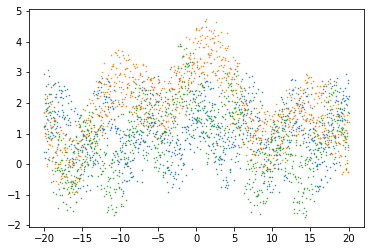

In [148]:
data_n = 1000

# timesteps = 24 # 16: 86%, 20: 88%, 24: 97%
# scope = 10

# timesteps = 20
# scope = 150 # 50: 88%, 80: 90%, 120: 93%, 150: 90%!

timesteps = 32 # 16: 84%, 32: 99%
scope = 20

df = make_data(-scope, scope, data_n, timesteps)
data_n = df.shape[0]
train_n = int(data_n * 0.8)
test_n = int(data_n * 0.2)
train_df = df.iloc[:train_n]
test_df = df.iloc[train_n:]

In [149]:
class ArgMax(layers.Layer):
  def __init__(self):
    super(ArgMax, self).__init__()

  def call(self, inputs):
    print(type(inputs))
    return float(tf.math.argmax(inputs, axis=1))

input_dim = 1
output_dim = classes

model = models.Sequential()
model.add(layers.Input(shape=(timesteps,)))
model.add(layers.Dense(timesteps * 4, activation='relu'))
model.add(layers.Dense(timesteps * 2, activation='relu'))
model.add(layers.Dense(output_dim, activation='softmax'))
model.compile(loss='categorical_crossentropy', metrics=['acc'])

# model.add(ArgMax())
model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_84 (Dense)            (None, 128)               4224      
                                                                 
 dense_85 (Dense)            (None, 64)                8256      
                                                                 
 dense_86 (Dense)            (None, 3)                 195       
                                                                 
Total params: 12,675
Trainable params: 12,675
Non-trainable params: 0
_________________________________________________________________


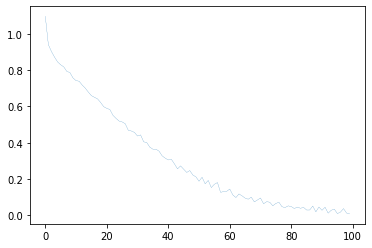

In [150]:
history = model.fit(test_df.values, utils.to_categorical(test_df.index), epochs=100, verbose=0)
plt.plot(history.history['loss'])

In [151]:
test_loss, test_acc = model.evaluate(test_df.values, utils.to_categorical(test_df.index))

19/19 [==============================] - 0s 2ms/step - loss: 0.0126 - acc: 1.0000


(581, 0)

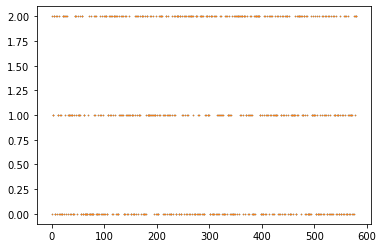

In [152]:
predicted_labels = np.argmax(model.predict(test_df.values), axis=-1)

plt.scatter(np.arange(len(test_df.index)), test_df.index)
plt.scatter(np.arange(len(predicted_labels)), predicted_labels)
equals = np.equal(test_df.index, predicted_labels)
list(equals).count(True), list(equals).count(False)